### <p style="text-align: right;"> &#9989; Lexi McFall</p>

# CMSE 202 Homework 03






### Assignment instructions

Work through the following assignment, making sure to follow all of the directions and answer all of the questions.

There are **25 points** possible on this assignment. Point values for each part are included in the section headers.

This assignment is due at 11:59 pm on **Friday October 23rd**. It should be uploaded into the "Homework Assignments" submission folder for Homework 3 in your D2L webpage. Submission instructions can be found at the end of the notebook.

**Hint**: It is possible you are asked to do something you are not familiar with. That's why you have internet access. Do some smart searches and see what you can find! 


### Our imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Part 1: Setting up a repository for tracking changes (3 points)

For this assignment, you're going to add it to the CMSE202 repository you created in class so that you can track your progress on the assignment and preserve the final version that you turn in. In order to do this you need to:

* Navigate to your `/CMSE202/repos` repository and create a new directory called `hw-03`.
* Move this notebook into that new directory in your repository, then add it and commit it to your repository.
 * Finally, to test that everything is working, "git push" the file so that it ends up in your GitHub repository.

Important: Make sure you've added your TA as a collaborators\ to your respository with "Read" access so that we can see your assignment.

* Section 001:  tuethan
* Section 002:  Luis-Polanco
* Section 003:  DavidRimel

Also important: Make sure that the version of this notebook that you are working on is the same one that you just added to your repository! If you are working on a different copy of the noteobok, none of your changes will be tracked.


If everything went as intended, the file should now show up on your GitHub account CMSE202 repository under the `hw-03` directory that you just created. Periodically, you'll be asked to commit your changes to the repository and push them to the remote GitHub location. Of course, you can always commit your changes more often than that, if you wish. It can be good to get into a habit of committing your changes any time you make a significant modification, or when you stop working on the project for a bit.

## Part 2: Load, prepare and plot the data (5 points)

In this homework we will be working with the yeast dataset and building logistic regression and k-nearest neighbors classifier class. The data file is *yeast.data* and its description is in *yeast.names*. Read the description and get a sense of the meaning of the dataset. In this part, we will load and clean up the data.

**Question 2.1 (1 point)** Load the *yeast.data* as a pandas dataframe and give appropriate names to the columns. Then drop the columns **sequence name**, **pox** and **vac**. What's the size of this dataset now?

In [4]:
### Put your code here ###
column_names=['Seq Name','mcg','gvh','alm','mit','erl','pox','vac','nuc','class']
yeast=pd.read_csv("yeast.data",sep='\s+', engine='python',names=column_names)

dropped=['Seq Name', 'pox','vac']

yeast=yeast.drop(dropped, axis=1)

yeast.tail() # the datset now is 7x1483

,mcg,gvh,alm,mit,erl,nuc,class
1479,0.81,0.62,0.43,0.17,0.5,0.22,ME2
1480,0.47,0.43,0.61,0.40,0.5,0.47,NUC
1481,0.67,0.57,0.36,0.19,0.5,0.22,ME2
1482,0.43,0.40,0.60,0.16,0.5,0.39,NUC
1483,0.65,0.54,0.54,0.13,0.5,0.22,CYT


**Question 2.2 (1 point)** Find the number of unqiue entries in the class label column

In [5]:
unique=yeast.groupby('class').nunique()
unique.shape[1]
print("The number of unique entries in the class label column is",unique.shape[1])

The number of unique entries in the class label column is 7


In [6]:
pd.value_counts(yeast['class'])

CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: class, dtype: int64

**Question 2.3 (1 point)** We are only interested in data with label **CYT (cytosolic or cytoskeletal)** and **MIT (mitochondrial)**. Make a new dataframe containing
data with only these two types of labels, and redefine label **CYT** into **0**, and **MIT** into **1**. What's the size of the dataset now?

In [7]:
# Find CYT and MIT rows
cyt_int=yeast.loc[yeast['class'] == 'CYT']
mit_int=yeast.loc[yeast['class'] == 'MIT']
cyt_int.loc[:,'class'] = 0
mit_int.loc[:,'class'] = 1

# add 2 dataframes together
interested = pd.concat([cyt_int,mit_int])

print("The datset is now shape",interested.shape)
interested.head()

The datset is now shape (707, 7)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,mcg,gvh,alm,mit,erl,nuc,class
5,0.51,0.40,0.56,0.17,0.5,0.22,0
9,0.40,0.39,0.60,0.15,0.5,0.30,0
12,0.40,0.42,0.57,0.35,0.5,0.25,0
15,0.46,0.44,0.52,0.11,0.5,0.22,0
16,0.47,0.39,0.50,0.11,0.5,0.40,0


**Question 2.4 (2 points)** Make a scatter plot including every sample in the dataset with: the mcg feature on the x-axis, the gvh feature on the y-axis, and different colors for each class label. Make your observation. Are the two classes distinguishable using only those two features?

Text(0.5, 1.0, 'gvh vs. mcg')

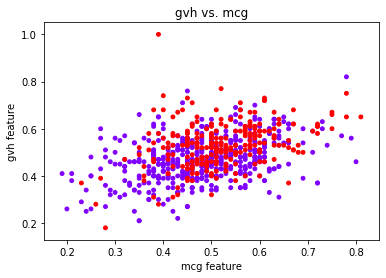

In [8]:
# Makes a scatter plot of mcg and gvh features
plt.scatter(interested['mcg'],interested['gvh'],c=interested['class'],s=15,cmap=plt.cm.rainbow)
plt.xlabel("mcg feature")
plt.ylabel("gvh feature")
plt.title("gvh vs. mcg")

# Logistic Regression

In the next part we will build a logistic regression model for the data classification.

## Part 3: Prepare data and build the logistic regression model (7 points)


**Question 3.1 (2 points)** Apply the "train_test_split" function in the *sklearn* package to split the data in 70% for training and 30% for testing.  Using common variable names like x_train, y_train, x_test and y_test might help later.

In [9]:
# train test split

from sklearn.model_selection import train_test_split

x_train,y_train,x_test,y_test = train_test_split(interested,interested['class'],test_size=.3)

**Question 3.2 (2 points)** Perform the logistic regression. 
* Discuss your results. How well does your model fit your data? What evidence are you using to make the determination? 
* Based on the P values under "P > |z|", which two features **in this dataset** are the least significant and can be dropped?

In [10]:
# doing the logistic regression
import statsmodels.api as sm

feats= interested.drop(columns = ['class'])

model=sm.OLS(interested['class'],feats)  # making and running the model
results=model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  class   R-squared (uncentered):                   0.576
Model:                            OLS   Adj. R-squared (uncentered):              0.573
Method:                 Least Squares   F-statistic:                              158.9
Date:                Tue, 20 Oct 2020   Prob (F-statistic):                   3.96e-127
Time:                        14:30:16   Log-Likelihood:                         -323.55
No. Observations:                 707   AIC:                                      659.1
Df Residuals:                     701   BIC:                                      686.5
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**The model does not fit our data very well. The R-squared value is only 0.576. This is a pretty poor R-squared value. The two features that appear to be the least significant and have P values of greater than 0.05 are mcg and nuc and they should be dropped from the model.**

**Question 3.3 (3 points)** Drop the two least important features found in the previous question and perform the logistic regression again. Then use the use the `sklearn.metrics` we imported at the top and run the `accuracy_score` on the 0/1 predicted label and the test labels, and print the accuracy of this model.

* Discuss your results. How well does your reduced model fit your data? What evidence are you using to make the determination?

In [12]:
### Put your code here ###
feats2= interested.drop(columns = ['class','mcg','nuc'])

model2=sm.OLS(interested['class'],feats2)  # making and running the model
results2=model2.fit()

print(results2.summary())


                                 OLS Regression Results                                
Dep. Variable:                  class   R-squared (uncentered):                   0.573
Model:                            OLS   Adj. R-squared (uncentered):              0.570
Method:                 Least Squares   F-statistic:                              235.8
Date:                Tue, 20 Oct 2020   Prob (F-statistic):                   2.70e-128
Time:                        14:30:39   Log-Likelihood:                         -326.37
No. Observations:                 707   AIC:                                      660.7
Df Residuals:                     703   BIC:                                      679.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# K-Nearest Neighbors

In the next part we will be building a class that will use the k-nearest neighbors algorithm (kNN) to make predictions on the same dataset. From the previous part (logistic regression), you have selected **4 features** that are important for classification. We will **only** use those 4 features in this part.


## Part 4: KNN classifier, cross-validation and hyperparameter tuning (10 points)

**Question 4.1 (3 points)** Test drive the KNN classifier. Use the same train and test data you created in question 3.4 to build a KNN classifier with K=3. 
- make a `KNeighborsClassifier` with an argument of `n_neighbors=3`. This returns a knn classifier (let's just call it `knn`)
- call `knn.fit` on the training data
- use `knn.predict` on the testing data to generate the predicted values.
- print the confusion matrix.
- print the train and test score using `knn.score`.
- plot the ROC curve with the diagonal (the "chance line") also labeled. Using `sklearn.metrics`, print the `auc` for this model.

In [79]:
### Put your code here ###
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)
y_predict = knn.predict(x_test)

ValueError: Found input variables with inconsistent numbers of samples: [494, 213]

## k-Fold Cross-Validation
Cross-validation is when the dataset is randomly split up into ‘k’ groups. One of the groups is used as the test set and the rest are used as the training set. The model is trained on the training set and scored on the test set. Then the process is repeated until each unique group as been used as the test set.
For example, for 5-fold cross validation, the dataset would be split into 5 groups, and the model would be trained and tested 5 separate times so each group would get a chance to be the test set. This can be seen in the graph below.

<img src="https://miro.medium.com/max/1400/1*NyvaFiG_jXcGgOaouumYJQ.jpeg" width=700px>

The train-test-split method we used in earlier is called ‘holdout’. Cross-validation is better than using the holdout method because the holdout method score is dependent on how the data is split into train and test sets. Cross-validation gives the model an opportunity to test on multiple splits so we can get a better idea on how the model will perform on unseen data.




**Question 4.2 (2 points)** Look up `cross_val_score` in `sklearn.model_selection`. We will still use n_neighbors=3, and  a cross-validation value of 5. `cross_val_score` takes in our k-NN model and our data as parameters. Then it splits our data into 5 groups and fits and scores our data 5 seperate times, recording the accuracy score in an array each time. We will save the accuracy scores in the cv_scores variable. Then find the average of the cv_scores, that will provide you a more accurate understanding of the accuracy of the model.

* Discuss your results. How well do your models fit your data? 
* What are you using to judge that fit (i.e., how should we think about the accuracy score as a measure of quality of the model)?
* How does the quality of the KNN model compare to logistic regression?

In [ ]:
### Put your code here ###


## Hyperparameter tuning


Almost all machine learning models have hyperparamters. Hyperparameters are setting(s) in the model that the user needs to choose before learning takes place. For example, in k-nearest neighbors, the number of neighbors to consider  n_neighbors, is the hyperparameter. An important task in machine learning is hyperparameter tuning, which is finding the optimal hyperparmeter. We will now explore the optimal choice of this parameter for this dataset.

**Question 4.3 (3 points)** Consider the range of `n_neighbors` from 1 to 100, and fix the cross-validation value to be 5. 
- For each value of n_neighbors, compute the means of the cv_scores. 
- Make a plot with the x-axis being n_neighbors, y-axis being the mean of cv_scores.
- Find the optimal choice of n_neighbors with the largest value of the mean of cv_scores.

Discuss your results
* How does the quality of this model compare to the earlier models that you made with KNN and logisitic regression?


In [ ]:
### Put your code here ###


Now we will use a more efficient method: `GridSearchCV` in `sklearn.model_selection` to find the optimal n_neighbors.

**Question 4.4 (2 points)** Look up `GridSearchCV` in `sklearn.model_selection`. We will still use a cross-validation value of 5.  Use `best_params_` in `GridSearchCV` to find the optimal n_neighbors. Does it agree with the results from question 4.3?

In [ ]:
### Put your code here ###



---
### Assignment wrap-up

Please fill out the form that appears when you run the code below.  **You must completely fill this out in order to receive credit for the assignment!**

In [ ]:
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://docs.google.com/forms/d/e/1FAIpQLSc0IBD2mdn4TcRyi-KNXVtS3aEg6U4mOFq2MOciLQyEP4bg1w/viewform?usp=sf_link" 
	width="800px" 
	height="600px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)

### Congratulations, you're done!

Submit this assignment by uploading it to the course Desire2Learn web page.  Go to the "Homework Assignments" folder, find the dropbox link for Homework 3, and upload your notebook **and the script you wrote**.